### Comparison between Algorithm 2 and Algorithm 3
#### Used for Figure 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from piston_Lagrangian import setup
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['text.usetex'] = True
plt.rcParams['animation.ffmpeg_path'] = r'/usr/local/bin/ffmpeg'
import itertools
from utils import max_error

In [3]:
def generate_input_CLAW(method, order_relaxation):
    far_field_damping = False
    scalar_far_field =False
    relaxation_method = False
    matrix_filter=False
    euler_RS = 'euler'
    solver_class = 'sharpclaw_custom'
    Strang = False
    before_stage = False

    if method == "RM":
        relaxation_method = True 
        
    elif method == "RM-M":
        relaxation_method = True
        matrix_filter = True

    else:
        print("###############################")
        print("Method not implemented")
        print("###############################")
        return 1
    
    if order_relaxation ==0: #Relaxation after each RK stage
            before_stage = True
    if order_relaxation ==2:
            Strang = True
    
    return (euler_RS, relaxation_method, far_field_damping,
            matrix_filter, scalar_far_field, solver_class,
            Strang, before_stage)

In [4]:
def set_and_run_CLAW(method, order_relaxation, data, adaptiveRM=False):
    (tfinal,xmax2,mx2,piston_freq,M,
    start_slowing,stop_slowing,
    start_absorbing,stop_absorbing) = data
    (euler_RS, relaxation_method, far_field_damping,
    matrix_filter, scalar_far_field, solver_class,
    Strang, before_stage) = generate_input_CLAW(method, order_relaxation=order_relaxation)
    piston_problem2 = setup(tfinal=tfinal, xmax=xmax2, mx=mx2, M=M, CFL=0.8,limiting=1,nout=100,
                        solver_type=solver_class, order=2, time_integrator='Heun',
                        euler_RS=euler_RS, 
                        relaxation_method=relaxation_method,
                        far_field_damping=far_field_damping,
                        matrix_filter=matrix_filter,
                        start_slowing=start_slowing, stop_slowing=stop_slowing,
                        start_absorbing=start_absorbing, stop_absorbing=stop_absorbing,
                        piston_freq=piston_freq,
                        sigma_damping_type="Mayer", 
                        sigma_slowing_type="Ensig-Karup2",
                        scalar_far_field=scalar_far_field,
                        before_stage=before_stage,
                        adaptiveRM=adaptiveRM,
                        Strang=Strang)
    piston_problem2.verbosity = 0
    piston_problem2.run()
    piston_problem2.solver.__del__()
    return piston_problem2

In [5]:
#sponge_layer_width_list = np.round(2*np.pi*np.array([0.25,0.5,1,4]))
def comparison_setup(sponge_layer_width_list,piston_freq=1., p=20, p_domain=30, p_ABC=20, p_domain_ABC=30, M=0.4, 
                    verbose=True, N=200, adaptiveRM=False):
    if verbose:
        print("#################################################################")
        print("RUNNING SIMULATION WITH PARAMETERS:\npiston_freq = ", piston_freq,
         ", p = ", p, ", p_domain = ", p_domain, ", M = ", M)

    #Reference solution
    xmax1 = p_domain*2*np.pi #p*2*np.pi
    #N = 200 #Cells per period at final time
    mx1 = p_domain*N #Number of grid points
    tfinal = p*2*np.pi

    #Run reference solution
    piston_problem1 = setup(tfinal=tfinal, xmax=xmax1, mx=mx1, M=M, CFL=0.8,limiting=1,solver_type='sharpclaw',
    order=2, time_integrator='Heun', nout=100, piston_freq=piston_freq)
    piston_problem1.verbosity = 0
    piston_problem1.run()
    piston_problem1.solver.__del__()

    #Run "truncated" solutions
    xmax2 = p_domain_ABC*2*np.pi #p*2*np.pi
    #N = 200 #Cells per period at final time
    mx2 = p_domain_ABC*N #Number of grid points

    method_list = ["RM","RM-M"]
    orders_relaxation = [1,2,0]
    #Combine all methods in tuples
    method_list = list(itertools.product(method_list,orders_relaxation))
    method_list_names = [str(met[0])+"-"+str(met[1]) for met in method_list]
    

    start_slowing = p_ABC*np.pi #p_ABC*2*np.pi
    start_absorbing = p_ABC*np.pi #p_ABC*2*np.pi

    error_list=[]
    for width in sponge_layer_width_list:
        if verbose:
            print("Layer width = ", width)
        stop_slowing = start_absorbing + width*2*np.pi
        stop_absorbing = start_absorbing + width*2*np.pi
        data = (tfinal,xmax2,mx2,piston_freq,M,
            start_slowing,stop_slowing,
            start_absorbing,stop_absorbing) 

        x_comparison = min(start_slowing,start_absorbing)
        error_list.append([])
        for method in method_list:
            met = method[0]
            order_relaxation = method[1]
            if verbose:
                print("Running ", met, " with order ", order_relaxation)
            piston_problem2 = set_and_run_CLAW(met,order_relaxation, data, adaptiveRM=adaptiveRM)
            indx = np.where(piston_problem2.grid.x.centers<=x_comparison)
            error_list[-1].append(max_error(piston_problem1,piston_problem2,indx=indx))
            if not np.allclose(piston_problem1.grid.x.centers[indx],piston_problem2.grid.x.centers[indx]):
                raise ValueError("Grids are not the same!!!")
            if verbose:
                print(met," with relaxation after each RK stage DONE")
                
    if verbose:
        print("#################################################################")
    return np.array(error_list)

# Running comparison 

In [6]:
#list_sponge_layer_widths = np.round(np.logspace(np.log10(0.001),np.log10(2.),10),3)
list_sponge_layer_widths = np.round(np.logspace(np.log10(0.01),np.log10(10.),11),2)

In [7]:
N_per_period = [10, 50, 250]
#list_error_arrays04 = [[] for i in range(len(N_per_period))]
M = 0.4

for N in N_per_period:
    error_list = comparison_setup(sponge_layer_width_list=list_sponge_layer_widths, M=M,
                                piston_freq=1., p=20, p_domain=30, p_ABC=20, p_domain_ABC=30, N=N)
    print("#################################################################")
    print("Error list: ",error_list)
    print("#################################################################")
    np.savetxt("./data_First_Second/N="+str(N)+".txt",error_list)

#################################################################
RUNNING SIMULATION WITH PARAMETERS:
piston_freq =  1.0 , p =  20 , p_domain =  30 , M =  0.4
Layer width =  0.01
Running  RM  with order  1
RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.02
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.04
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.08
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.16
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.32
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.63
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  1.26
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  2.51
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  5.01
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  10.0
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'
Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'SharpClawSolver1D' object has no attribute 'fmod'
Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
#################################################################
#################################################################
Error list:  [[9.98242330e-03 9.98242330e-03 9.98242330e-03 9.98242330e-03
  9.98242330e-03 9.98242330e-03]
 [9.98242330e-03 9.98242330e-03 9.98242330e-03 9.98242330e-03
  9.98242330e-03 9.98242330e-03]
 [9.98242330e-03 9.98242330e-03 9.98242330e-03 9.98242330e-03
  9.98242330e-03 9.98242330e-03]
 [8.10715032e-03 8.10715032e-03 8.10715032e-03 8.10715032e-03
  8.10715032e-03 8.10715032e-03]
 [7.33235402e-03 7.33235402e-03 7.22813906e-03 7.44204723e-03
  7.44204723e-03 7.38484539e-03]
 [7.09620588e-03 7.09620588e-03 6.74343401e-03 7.52769836e-03
  7.52769836e-03 7.32456509e-03]
 [2.46771363e-03 2.46771363e-03 1.79286292e-03 4.05822203e-03
  4.05822203e-03 3.15619334e-03]
 [3.90712314e-04 3.90712314e-04 3.97560792e-04 5.85549494e-04
  5.85549494e-04 3.95921312e-04]
 [1.82060740e-04 1.82060740e-04 1.90940780e-04 2

Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.02
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.04
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.08
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.16
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.32
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.63
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  1.26
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  2.51
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  5.01
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  10.0
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'
Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'SharpClawSolver1D' object has no attribute 'fmod'
Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
#################################################################
#################################################################
Error list:  [[5.16342462e-02 5.16342462e-02 5.16342462e-02 5.16342462e-02
  5.16342462e-02 5.16342462e-02]
 [5.16342462e-02 5.16342462e-02 5.16342462e-02 5.16342462e-02
  5.16342462e-02 5.16342462e-02]
 [5.20051544e-02 5.20051544e-02 5.15496064e-02 5.24142297e-02
  5.24142297e-02 5.21553193e-02]
 [3.59013653e-02 3.59013653e-02 2.78718289e-02 4.29581645e-02
  4.29581645e-02 3.44031456e-02]
 [5.43334422e-03 5.43334422e-03 3.53040567e-03 9.43870608e-03
  9.43870608e-03 6.85842419e-03]
 [2.15186254e-03 2.15186254e-03 2.33619456e-03 5.16574997e-04
  5.16574997e-04 1.21129375e-03]
 [9.58407013e-04 9.58407013e-04 1.08401566e-03 5.91803309e-04
  5.91803309e-04 7.95534692e-04]
 [2.68518540e-04 2.68518540e-04 3.39890739e-04 2.76602076e-04
  2.76602076e-04 3.19787144e-04]
 [6.58935599e-05 6.58935599e-05 7.57374736e-05 6

Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.02
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.04
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.08
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.16
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.32
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  0.63
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  1.26
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  2.51
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  5.01
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Layer width =  10.0
Running  RM  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM  with relaxation after each RK stage DONE
Running  RM-M  with order  1


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  2


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
Running  RM-M  with order  0


Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'
Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'SharpClawSolver1D' object has no attribute 'fmod'
Exception ignored in: <function SharpClawSolver.__del__ at 0x11bc49310>
Traceback (most recent call last):
  File "/Users/munozmca/clawpack/pyclaw/src/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'customSharpClawSolver1D' object has no attribute 'fmod'


RM-M  with relaxation after each RK stage DONE
#################################################################
#################################################################
Error list:  [[5.23445038e-02 5.23445038e-02 4.47621125e-02 6.10764310e-02
  6.10764310e-02 5.36624292e-02]
 [3.55004582e-02 3.55004582e-02 2.40752732e-02 5.18420496e-02
  5.18420496e-02 3.67507413e-02]
 [5.26095533e-03 5.26095533e-03 4.04283059e-03 4.78873334e-03
  4.78873334e-03 6.02627927e-03]
 [3.67511451e-03 3.67511451e-03 3.66472849e-03 1.08311103e-03
  1.08311103e-03 9.14610763e-04]
 [1.50669150e-03 1.50669150e-03 1.65036716e-03 1.07309482e-03
  1.07309482e-03 7.17825647e-04]
 [5.07360236e-04 5.07360236e-04 5.88719290e-04 3.49312260e-04
  3.49312260e-04 3.90562228e-04]
 [1.48263372e-04 1.48263372e-04 1.84995639e-04 1.85969074e-04
  1.85969074e-04 1.94960568e-04]
 [3.37258214e-05 3.37258214e-05 4.76532227e-05 5.52369387e-05
  5.52369387e-05 7.33437558e-05]
 [1.10752442e-05 1.10752442e-05 1.32329879e-05 1

In [8]:
N_per_period = [10, 50, 250]
list_error_arrays= [[] for i in range(len(N_per_period))]

for i,N in enumerate(N_per_period):
    list_error_arrays[i] = np.loadtxt("./data_First_Second/N="+str(N)+".txt")

list_titles = ["N = "+str(N) for N in N_per_period]

In [9]:
import matplotlib as mpl
def plot_errors_diff_Nx(list_error_arrays, list_titles,sponge_layer_width_list, ylim=None, list_ylim=None, logscales=[]):
    #Create a figure with len(error_list_np) axes in a column
    plt.close()
    fig,ax = plt.subplots(len(list_error_arrays),1,figsize=(5,2*len(list_error_arrays)),dpi=300)

    #######################
    #Sorry for the hardcoding
    #Self-convergence error (Self_convergence.ipynb)
    convError = np.array([4.451850711258536, 0.3165881764960132, 0.025595812908096895])
    #Constant extrapolation error (Constant_Extrapolation_Error.ipynb)
    constExtrapError = np.array([0.02019511774292874, 0.008940720159966534, 0.011296834045410153])
    #######################

    method_list = ["RM","RM-M"]
    orders_relaxation = [1,2]
    #Combine all methods in tuples
    method_list = list(itertools.product(method_list,orders_relaxation))
    method_list_names = [str(met[0])+"-"+str(met[1]) for met in method_list]
    method_list = ['RM ', 'RM 2', 'RM RK', 'RM-M ', 'RM-M 2', 'RM-M RK']

    #method_list = ["RM","RM+SO","RM+M","RM+SO","SDO","SDO scalar", "SDO integral"]
    color_list = ['blue','red','green','orange','purple','brown']#, 'black']
    linetype_list = ['solid','dashed','dotted','solid','dashed',"dotted"]#, "dotted"]
    marker_list = ['o','o','o','x','x','x']
    
    for i,error_list_np in enumerate(list_error_arrays):
        ax[i].set_xscale('log')
        if i<len(logscales):
            if logscales[i]:
                ax[i].set_yscale('log')
        #remove all minor ticks in x and y axis
        ax[i].xaxis.set_minor_locator(mpl.ticker.NullLocator())
        ax[i].yaxis.set_minor_locator(mpl.ticker.NullLocator())
        # Set the tick locations to be the values from the sponge_layer_width_list
        if i==len(list_error_arrays)-1:
            ax[i].set_xticks(sponge_layer_width_list)
            xtickslabels = np.round(sponge_layer_width_list,2)
            xtickslabels[:3] = [f"{width:.2e}" for width in sponge_layer_width_list[:3]]
            ax[i].set_xticklabels(xtickslabels)
            ax[i].xaxis.set_tick_params(which='minor', bottom=False)
        #Forcing the x-axis to be between 0.23 and 11
        ax[i].set_xlim(sponge_layer_width_list[0],sponge_layer_width_list[-1])
        if ylim is not None:
            ax[i].set_ylim(ylim)
        if list_ylim is not None:
            ax[i].set_ylim(list_ylim[i])
        # Remove the unwanted ticks
        
        ax[i].set_xlabel("Sponge layer length/wavelength "+r'($\omega/L$)')
        #ax[i].set_xlabel(r'$L/\omega$')

        ax[i].axvline(x=1,linestyle='--',color='black',linewidth=0.5)
        linelist = [] #For labels
        for j,method in enumerate(method_list):
            # if method not in ["RM RK","RM-M RK"]:
            line, = ax[i].plot(sponge_layer_width_list,error_list_np[:,j],color=color_list[j],linewidth=2,
                        linestyle=linetype_list[j],label=method, marker=marker_list[j])
            linelist.append(line)
            #ax[i].scatter(sponge_layer_width_list,error_list_np[:,j],color=color_list[j],marker=marker_list[j] )

            #Connect the points with a thin line    
        if i==1:
            ax[i].set_ylabel("Error ABC")
        if i==0:
             ax[i].legend(handles=linelist, loc="center left")
        ax[i].set_title(list_titles[i])
        ax[i].set_title(list_titles[i])
        #hline1 = ax[i].hlines(convError[i],0.01,5,linestyles='-.',colors='black',label="Numerical Error")
        hline1, =ax[i].plot(sponge_layer_width_list,
                        convError[i]*np.ones_like(sponge_layer_width_list),
                        linestyle='-.',
                        color='black',marker='^',label="Discretization Error")
        #hline2 = ax[i].hlines(constExtrapError[i],0.01,5,linestyles=':',colors='grey',
                     #label="Constant Extrapolation")
        hline2, =ax[i].plot(sponge_layer_width_list,
                      constExtrapError[i]*np.ones_like(sponge_layer_width_list),
                      linestyle=':',
                      color='grey',marker='*',label="Const. Extrap. Error") 
        handles = [hline1,hline2]
        if i==1:
            ax[i].legend(handles=handles,loc='lower left')
            

    plt.show()

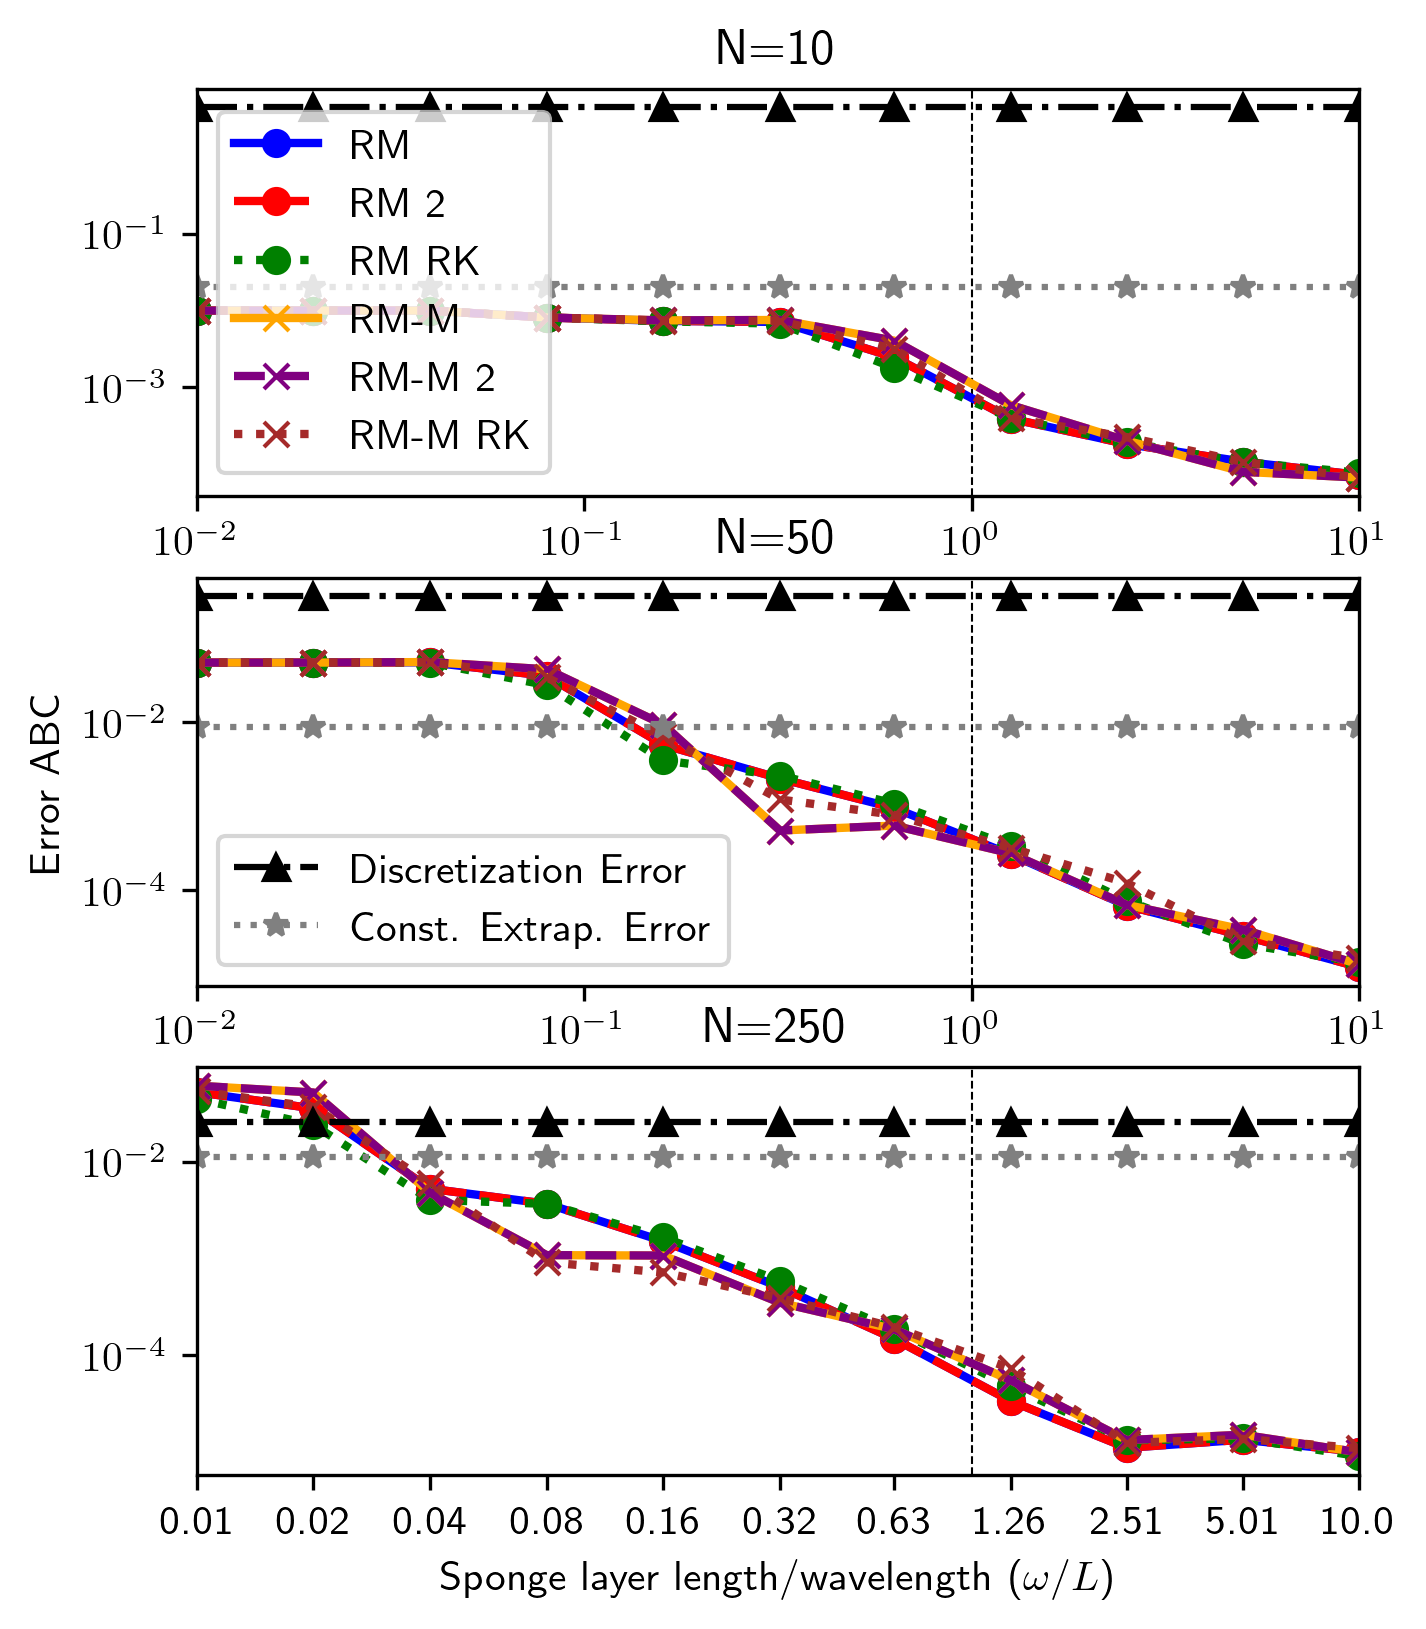

In [10]:
plot_errors_diff_Nx(list_error_arrays, list_titles=["N=10","N=50","N=250"], sponge_layer_width_list=list_sponge_layer_widths, ylim=None, list_ylim=None, logscales=[True,True,True])